In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import brainpy as bp
import brainpy.math as bm
from scipy.sparse import csr_matrix

bm.set_platform("cpu")

# Add project root to path to ensure imports work
project_root = os.path.abspath("..")
sys.path.insert(0, project_root)

from models.network import run_simulation

np.random.seed(42)
bm.random.seed(42)

/Users/mablin/Projects/github.com/mablin7/cerebellum-jax/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Metal device set to: Apple M3

systemMemory: 24.00 GB
maxCacheSize: 8.00 GB



W0000 00:00:1743342598.214119 13836524 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1743342598.223374 13836524 service.cc:145] XLA service 0x1360b6260 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743342598.223386 13836524 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1743342598.226950 13836524 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1743342598.226962 13836524 mps_client.cc:384] XLA backend will use up to 17178099712 bytes on device 0 for SimpleAllocator.


In [2]:
runner = run_simulation(duration=4_000)
mon = runner.mon

Running simulation for 4000ms with dt=0.025ms...


Predict 160000 steps: : 100%|██████████| 160000/160000 [00:31<00:00, 5114.10it/s] 

Simulation finished.


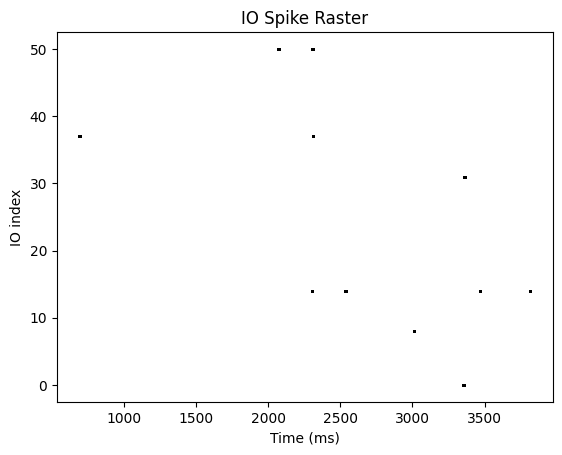

In [3]:
bp.visualize.raster_plot(
    runner.mon.ts,
    runner.mon["io.V_soma"] > -30.0,
    xlabel="Time (ms)",
    ylabel="IO index",
    title="IO Spike Raster",
)

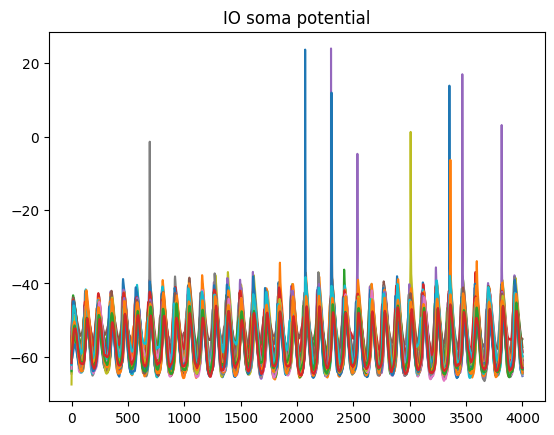

In [4]:
plt.plot(runner.mon.ts, runner.mon["io.V_soma"][:])
plt.title("IO soma potential")
plt.show()


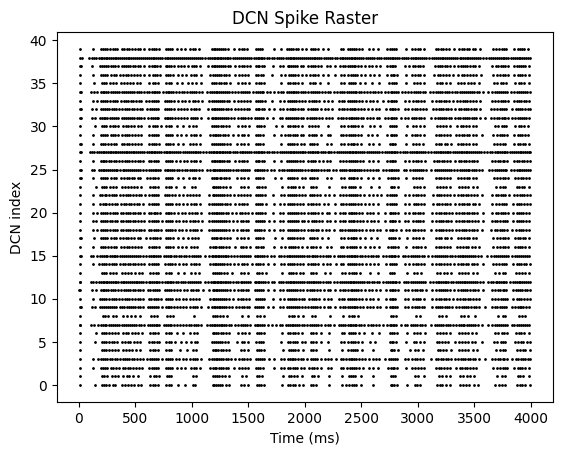

In [6]:
# dcn raster plot
bp.visualize.raster_plot(
    runner.mon.ts,
    runner.mon["cn.spike"],
    xlabel="Time (ms)",
    ylabel="DCN index",
    title="DCN Spike Raster",
)

/var/folders/xd/wcxw_5hn6rz2brc42jwv7f7r0000gn/T/ipykernel_23923/895330963.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


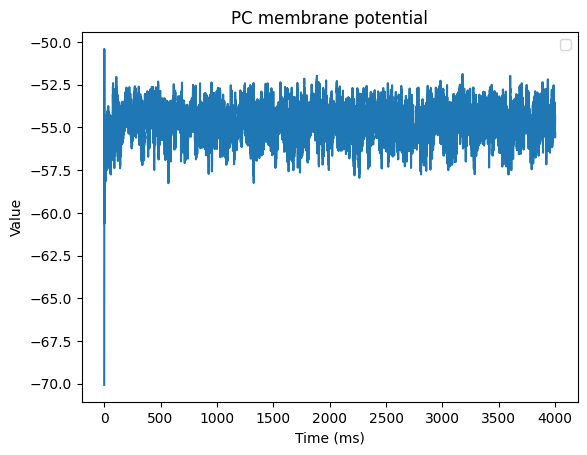

In [6]:
mon = runner.mon

plt.plot(mon.ts, np.mean(mon["pc.V"], axis=1))
# plt.plot(mon.ts, mon["cn_to_io.I_inhib"][:, :5])
plt.xlabel("Time (ms)")
plt.ylabel("Value")
plt.title("PC membrane potential")
plt.legend()
plt.show()

In [8]:
def calculate_firing_frequency(spike_data, time_data, window_size=50.0):
    """
    Calculate the firing frequency over time using a sliding window.

    Args:
        spike_data: Array of shape (time_steps, num_neurons) containing spike data (0 or 1)
        time_data: Array of time points
        window_size: Size of the sliding window in ms

    Returns:
        times: Time points for the frequency data
        frequencies: Average firing frequency across all neurons in Hz
    """
    dt = time_data[1] - time_data[0]
    window_steps = int(window_size / dt)

    n_steps, n_neurons = spike_data.shape

    frequencies = np.zeros(n_steps - window_steps)
    times = time_data[window_steps:]

    for i in range(len(frequencies)):
        spike_count = np.sum(spike_data[i : i + window_steps])

        frequencies[i] = spike_count / (window_size / 1000.0) / n_neurons

    return times, frequencies

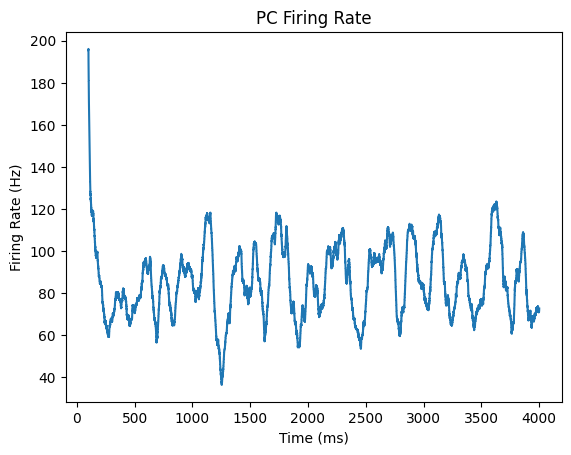

In [9]:
# plot PC firing rate
pc_firing_rate =  calculate_firing_frequency(mon["pc.spike"], mon.ts, 100)

plt.plot(pc_firing_rate[0], pc_firing_rate[1])
plt.xlabel("Time (ms)")
plt.ylabel("Firing Rate (Hz)")
plt.title("PC Firing Rate")
plt.show()


In [12]:
# Define a helper for histogram bins
def _get_bins(data):
    # ... (implementation as before) ...
    if len(data) == 0: return np.arange(2) - 0.5
    min_val = np.min(data); max_val = np.max(data)
    return np.arange(min_val - 0.5, max_val + 1.5, 1)

def plot_network_connectivity(net: bp.DynSysGroup, filename="connectivity_report.png"):
    """
    Generates plots to visualize and verify network connectivity, including
    degree distributions and sparsity patterns.

    Args:
        net: The initialized CerebellarNetwork instance.
        filename: The name of the file to save the plot grid.
    """
    print("Generating connectivity report...")

    try:
        num_pf = net.pf.num
        num_pc = net.pc.num
        num_cn = net.cn.num
        num_io = net.io.neurons.num
        num_io_projecting = num_io // 2
    except AttributeError as e:
        print(f"Error accessing population sizes: {e}")
        return

    fig, axes = plt.subplots(5, 3, figsize=(15, 22)) # 5 rows, 3 cols
    fig.suptitle("Network Connectivity Verification", fontsize=18, y=0.99)

    # --- 1. PF -> PC ---
    ax_pfpc_out, ax_pfpc_in, ax_pfpc_spy = axes[0, 0], axes[0, 1], axes[0, 2]
    try:
        # Use pre2post for PF Out-degree
        post_indices_p2p, post_indptr_p2p = net.pf_to_pc.conn.require('pre2post')
        pf_out_degree = np.diff(np.asarray(post_indptr_p2p))
        ax_pfpc_out.hist(pf_out_degree, bins=_get_bins(pf_out_degree))
        ax_pfpc_out.set_title(f"PF Out-Degree (to PC)")
        ax_pfpc_out.set_xlabel("Number of PC targets per PF")
        ax_pfpc_out.set_ylabel("Count")

        # Use post2pre for PC In-degree
        pre_indices_p2p, pre_indptr_p2p = net.pf_to_pc.conn.require('post2pre')
        pc_in_degree_pf = np.diff(np.asarray(pre_indptr_p2p))
        ax_pfpc_in.hist(pc_in_degree_pf, bins=_get_bins(pc_in_degree_pf))
        ax_pfpc_in.set_title(f"PC In-Degree (from PF, expecting 5)")
        ax_pfpc_in.set_xlabel("Number of PF inputs per PC")
        ax_pfpc_in.set_ylabel("Count")

        # Reconstruct pre_ids/post_ids for sparsity plot from post2pre
        post_ids_rec = np.arange(num_pc).repeat(pc_in_degree_pf)
        pre_ids_rec = np.asarray(pre_indices_p2p)
        if len(pre_ids_rec) == len(post_ids_rec): # Basic check
             conn_matrix_pfpc = csr_matrix((np.ones_like(pre_ids_rec), (pre_ids_rec, post_ids_rec)), shape=(num_pf, num_pc))
             ax_pfpc_spy.spy(conn_matrix_pfpc, markersize=1, aspect='auto')
             ax_pfpc_spy.set_title("PF -> PC Sparsity")
             ax_pfpc_spy.set_xlabel("PC Index")
             ax_pfpc_spy.set_ylabel("PF Index")
        else:
             print("Error reconstructing PF->PC for sparsity plot.")
             ax_pfpc_spy.set_title("PF -> PC Sparsity (Error)")


    except Exception as e:
        print(f"Could not plot PF->PC connectivity: {e}")
        # ... (error handling as before) ...
        ax_pfpc_out.set_title("PF Out-Degree (Error)")
        ax_pfpc_in.set_title("PC In-Degree (PF) (Error)")
        ax_pfpc_spy.set_title("PF -> PC Sparsity (Error)")


    # --- 2. PC -> CN ---
    ax_pccn_out, ax_pccn_in, ax_pccn_spy = axes[1, 0], axes[1, 1], axes[1, 2]
    try:
        # Use pre2post for PC Out-degree
        post_indices_p2p, post_indptr_p2p = net.pc_to_cn.conn.require('pre2post')
        pc_out_degree_cn = np.diff(np.asarray(post_indptr_p2p))
        ax_pccn_out.hist(pc_out_degree_cn, bins=_get_bins(pc_out_degree_cn))
        ax_pccn_out.set_title("PC Out-Degree (to CN, expecting 16)")
        ax_pccn_out.set_xlabel("Number of CN targets per PC")
        ax_pccn_out.set_ylabel("Count")

        # Use post2pre for CN In-degree
        pre_indices_p2p, pre_indptr_p2p = net.pc_to_cn.conn.require('post2pre')
        cn_in_degree_pc = np.diff(np.asarray(pre_indptr_p2p))
        ax_pccn_in.hist(cn_in_degree_pc, bins=_get_bins(cn_in_degree_pc))
        ax_pccn_in.set_title("CN In-Degree (from PC, avg ~40 [30-52])")
        ax_pccn_in.set_xlabel("Number of PC inputs per CN")
        ax_pccn_in.set_ylabel("Count")

        # Reconstruct pre_ids/post_ids for sparsity plot from pre2post
        pre_ids_rec = np.arange(num_pc).repeat(pc_out_degree_cn)
        post_ids_rec = np.asarray(post_indices_p2p)
        if len(pre_ids_rec) == len(post_ids_rec):
            conn_matrix_pccn = csr_matrix((np.ones_like(pre_ids_rec), (pre_ids_rec, post_ids_rec)), shape=(num_pc, num_cn))
            ax_pccn_spy.spy(conn_matrix_pccn, markersize=1, aspect='auto')
            ax_pccn_spy.set_title("PC -> CN Sparsity")
            ax_pccn_spy.set_xlabel("CN Index")
            ax_pccn_spy.set_ylabel("PC Index")
        else:
            print("Error reconstructing PC->CN for sparsity plot.")
            ax_pccn_spy.set_title("PC -> CN Sparsity (Error)")

    except Exception as e:
        print(f"Could not plot PC->CN connectivity: {e}")
        # ... (error handling as before) ...
        ax_pccn_out.set_title("PC Out-Degree (CN) (Error)")
        ax_pccn_in.set_title("CN In-Degree (PC) (Error)")
        ax_pccn_spy.set_title("PC -> CN Sparsity (Error)")


    # --- 3. CN -> IO ---
    ax_cnio_out, ax_cnio_in, ax_cnio_spy = axes[2, 0], axes[2, 1], axes[2, 2]
    try:
        # Use pre2post for CN Out-degree
        post_indices_p2p, post_indptr_p2p = net.cn_to_io.conn.require('pre2post')
        cn_out_degree_io = np.diff(np.asarray(post_indptr_p2p))
        ax_cnio_out.hist(cn_out_degree_io, bins=_get_bins(cn_out_degree_io))
        ax_cnio_out.set_title("CN Out-Degree (to IO, expecting 10)")
        ax_cnio_out.set_xlabel("Number of IO targets per CN")
        ax_cnio_out.set_ylabel("Count")

        # Use post2pre for IO In-degree
        pre_indices_p2p, pre_indptr_p2p = net.cn_to_io.conn.require('post2pre')
        io_in_degree_cn = np.diff(np.asarray(pre_indptr_p2p))
        ax_cnio_in.hist(io_in_degree_cn, bins=_get_bins(io_in_degree_cn))
        avg_in = np.mean(io_in_degree_cn) if len(io_in_degree_cn) > 0 else 0
        ax_cnio_in.set_title(f"IO In-Degree (from CN, avg ~{avg_in:.1f} [6-16])") # Note avg ~6.25 expected
        ax_cnio_in.set_xlabel("Number of CN inputs per IO")
        ax_cnio_in.set_ylabel("Count")

        # Reconstruct pre_ids/post_ids for sparsity plot from pre2post
        pre_ids_rec = np.arange(num_cn).repeat(cn_out_degree_io)
        post_ids_rec = np.asarray(post_indices_p2p)
        if len(pre_ids_rec) == len(post_ids_rec):
            conn_matrix_cnio = csr_matrix((np.ones_like(pre_ids_rec), (pre_ids_rec, post_ids_rec)), shape=(num_cn, num_io))
            ax_cnio_spy.spy(conn_matrix_cnio, markersize=1, aspect='auto')
            ax_cnio_spy.set_title("CN -> IO Sparsity")
            ax_cnio_spy.set_xlabel("IO Index")
            ax_cnio_spy.set_ylabel("CN Index")
        else:
            print("Error reconstructing CN->IO for sparsity plot.")
            ax_cnio_spy.set_title("CN -> IO Sparsity (Error)")

    except Exception as e:
        print(f"Could not plot CN->IO connectivity: {e}")
        # ... (error handling as before) ...
        ax_cnio_out.set_title("CN Out-Degree (IO) (Error)")
        ax_cnio_in.set_title("IO In-Degree (CN) (Error)")
        ax_cnio_spy.set_title("CN -> IO Sparsity (Error)")


    # --- 4. IO -> PC ---
    ax_iopc_out, ax_iopc_in, ax_iopc_spy = axes[3, 0], axes[3, 1], axes[3, 2]
    try:
        # Use post2pre for PC In-degree (expecting 1) and source IOs
        pre_indices_p2p, pre_indptr_p2p = net.io_to_pc.conn.require('post2pre')
        pc_in_degree_io = np.diff(np.asarray(pre_indptr_p2p))
        ax_iopc_in.hist(pc_in_degree_io, bins=_get_bins(pc_in_degree_io))
        ax_iopc_in.set_title("PC In-Degree (from IO, expecting 1)")
        ax_iopc_in.set_xlabel("Number of IO inputs per PC")
        ax_iopc_in.set_ylabel("Count")

        # Calculate Out-degree for projecting IOs using the source indices
        io_source_indices = np.asarray(pre_indices_p2p) # Indices of source IO for each PC
        projecting_mask = io_source_indices < num_io_projecting
        projecting_source_ids = io_source_indices[projecting_mask]

        if num_io_projecting > 0:
             io_out_degree_pc = np.bincount(projecting_source_ids, minlength=num_io_projecting)
             ax_iopc_out.hist(io_out_degree_pc, bins=_get_bins(io_out_degree_pc))
             avg_out = np.mean(io_out_degree_pc) if len(io_out_degree_pc) > 0 else 0
             ax_iopc_out.set_title(f"Projecting IO Out-Degree (to PC, avg ~{avg_out:.1f} [2-9?])") # Note avg ~3.1 expected
        else:
             ax_iopc_out.set_title("Projecting IO Out-Degree (No Proj. IOs!)")
        ax_iopc_out.set_xlabel("Number of PC targets per Projecting IO")
        ax_iopc_out.set_ylabel("Count")

        # Reconstruct pre/post for sparsity plot (only projecting IOs)
        post_ids_rec = np.arange(num_pc)[projecting_mask] # PCs connected to projecting IOs
        pre_ids_rec = projecting_source_ids # Source IOs for these PCs
        if len(pre_ids_rec) == len(post_ids_rec) and num_io_projecting > 0:
             conn_matrix_iopc = csr_matrix((np.ones_like(pre_ids_rec), (pre_ids_rec, post_ids_rec)),
                                          shape=(num_io_projecting, num_pc))
             ax_iopc_spy.spy(conn_matrix_iopc, markersize=1, aspect='auto')
             ax_iopc_spy.set_title(f"IO -> PC Sparsity ({num_io_projecting} Proj. IOs)")
             ax_iopc_spy.set_xlabel("PC Index")
             ax_iopc_spy.set_ylabel("Projecting IO Index")
        else:
             ax_iopc_spy.set_title("IO -> PC Sparsity (Error/No Proj.)")

    except Exception as e:
        print(f"Could not plot IO->PC connectivity: {e}")
        # ... (error handling as before) ...
        ax_iopc_out.set_title("Proj. IO Out-Degree (Error)")
        ax_iopc_in.set_title("PC In-Degree (IO) (Error)")
        ax_iopc_spy.set_title("IO -> PC Sparsity (Error)")


    # --- 5. IO <-> IO (Gap Junctions) ---
    # ... (code remains the same as previous version) ...
    ax_ioio_out, ax_ioio_in, ax_ioio_spy = axes[4, 0], axes[4, 1], axes[4, 2]
    try:
        # Access GJ indices directly from the IONetwork's neuron population
        if hasattr(net.io, 'neurons') and hasattr(net.io.neurons, 'gj_src') and hasattr(net.io.neurons, 'gj_tgt'):
            gj_src = np.asarray(net.io.neurons.gj_src)
            gj_tgt = np.asarray(net.io.neurons.gj_tgt)

            # Out-degree (GJ)
            io_out_degree_gj = np.bincount(gj_src, minlength=num_io)
            ax_ioio_out.hist(io_out_degree_gj, bins=_get_bins(io_out_degree_gj))
            avg_out = np.mean(io_out_degree_gj) if len(io_out_degree_gj) > 0 else 0
            ax_ioio_out.set_title(f"IO Gap Junction Out-Degree (avg ~{avg_out:.1f} [~10])")
            ax_ioio_out.set_xlabel("Number of GJ targets per IO")
            ax_ioio_out.set_ylabel("Count")

            # In-degree (GJ)
            io_in_degree_gj = np.bincount(gj_tgt, minlength=num_io)
            ax_ioio_in.hist(io_in_degree_gj, bins=_get_bins(io_in_degree_gj))
            avg_in = np.mean(io_in_degree_gj) if len(io_in_degree_gj) > 0 else 0
            ax_ioio_in.set_title(f"IO Gap Junction In-Degree (avg ~{avg_in:.1f} [~10])")
            ax_ioio_in.set_xlabel("Number of GJ inputs per IO")
            ax_ioio_in.set_ylabel("Count")

            # Sparsity Plot
            conn_matrix_ioio = csr_matrix((np.ones_like(gj_src), (gj_src, gj_tgt)), shape=(num_io, num_io))
            ax_ioio_spy.spy(conn_matrix_ioio, markersize=1, aspect='auto')
            ax_ioio_spy.set_title("IO <-> IO Gap Junction Sparsity")
            ax_ioio_spy.set_xlabel("Target IO Index")
            ax_ioio_spy.set_ylabel("Source IO Index")
        else:
            print("Gap junction attributes (gj_src, gj_tgt) not found on net.io.neurons.")
            ax_ioio_out.set_title("IO GJ Out-Degree (Not Found)")
            ax_ioio_in.set_title("IO GJ In-Degree (Not Found)")
            ax_ioio_spy.set_title("IO <-> IO GJ Sparsity (Not Found)")


    except Exception as e:
        print(f"Could not plot IO<->IO GJ connectivity: {e}")
        # ... (error handling as before) ...
        ax_ioio_out.set_title("IO GJ Out-Degree (Error)")
        ax_ioio_in.set_title("IO GJ In-Degree (Error)")
        ax_ioio_spy.set_title("IO <-> IO GJ Sparsity (Error)")


    # Adjust layout and save
    fig.tight_layout(rect=[0, 0.01, 1, 0.97])
    plt.show()

Generating connectivity report...


/Users/mablin/Projects/github.com/mablin7/cerebellum-jax/.venv/lib/python3.12/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/mablin/Projects/github.com/mablin7/cerebellum-jax/.venv/lib/python3.12/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will result in an error.
  warnings.warn(
/Users/mablin/Projects/github.com/mablin7/cerebellum-jax/.venv/lib/python3.12/site-packages/jax/_src/ops/scatter.py:92: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=int32 to dtype=uint32 with jax_numpy_dtype_promotion='standard'. In future JAX releases this will

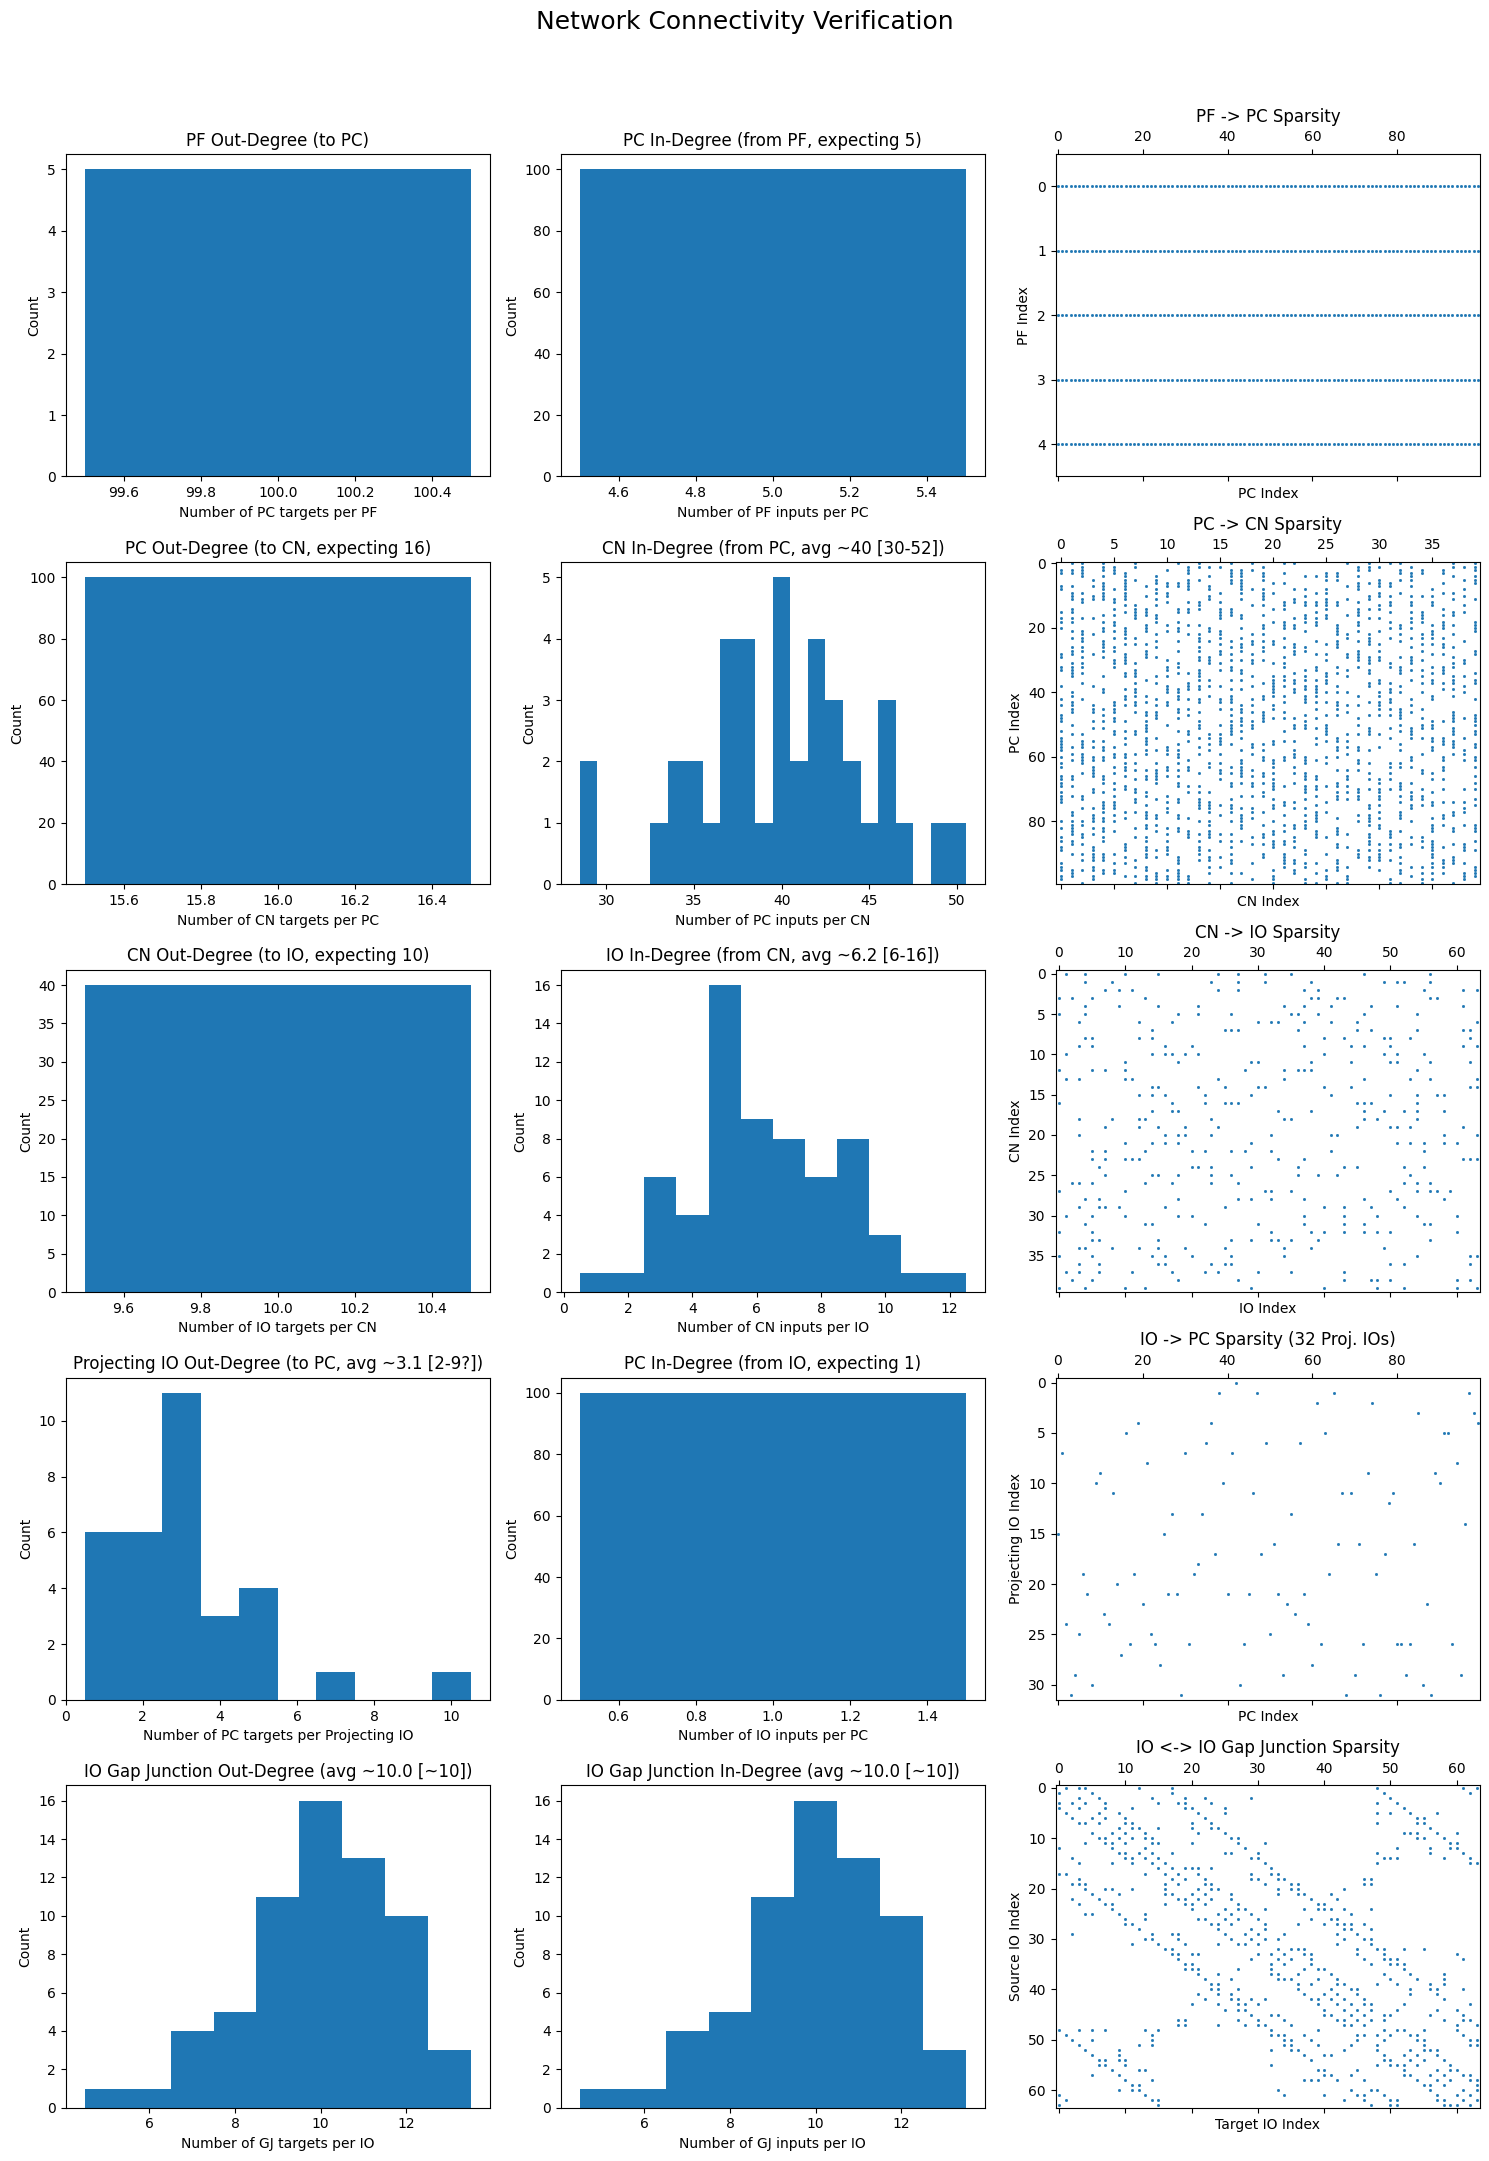

In [13]:
plot_network_connectivity(net)